# Text Classification with Sklearn
(Core)

*Christina Brockway*

## Make a copy  of last assignment and run notebook

Using:  https://www.gnu.org/licenses/agpl-3.0.html
downloaded from Kaggle

This data set contains labeled real and fake news articles from around the 2017 US presidential elections

Task:  Create a model to detect fake news articles

1.  Clean the data. Remove any unnecessary columns and check for/remove duplicates.xt

2.  Prepare the data. Create 3 new columns:
    1.  Tokenized texts:
        -  just split the texts, don't remove stopwords or punctuation  
    2.  Lemmatized texts:
        -  remove stopwords, and punctuation, and lemmatize the words
        -  IMPORTANT! When you load in the SpaCy NLP object, remember to disable the parser and named object recognizer using the following: spacy.load('en_core_web_sm', disable=['parser', 'ner']  
    3.  Join lemmatized data into a single string

3.  Analyze class balance and document lengths
    *  What is the class balance? How many real and fake articles are there?
    *  What is the average word count for real news articles? What about fake ones?

4.  Compare the word frequencies using joined lemmatized text
    *  Create and plot the frequency distribution plots for the 20 most common words in real and fake news articles. (2 total plots)
    *  Create word clouds for each of the article types, real and fake

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.probability import FreqDist
import nltk
import spacy 
from spacy.cli import download
download('en_core_web_sm') 

# New pandas option to change: 
pd.get_option('display.max_colwidth')
# Increase column width
pd.set_option('display.max_colwidth', 250)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1.  Clean the Data
Remove any unnecessary columns and check for/remove duplicates.

In [2]:
df = pd.read_csv('data/Fake_Real_News_Data.csv')
df.head(2)

,Unnamed: 0,title,text,label
0,0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. mi...",REAL
1,1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimo...",REAL


In [3]:
df= df.drop(columns='Unnamed: 0', errors='ignore')

In [4]:
df.duplicated().sum()

29

In [5]:
df = df.drop_duplicates()

In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [8]:
#Combine Title with Text
df['news'] = df['title'] + ": " + df['text']
df.head(2)

,title,text,label,news
0,A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone,"Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North Atlantic Treaty Organization and expressing skepticism about a muscular U.S. mi...",REAL,"A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone: Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North A..."
1,"In Baltimore's call for federal police probe, a new search for answers (+video)","While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves included as part of the solution.\n\nSearching for a ""framework ... [to] heal,"" Baltimo...",REAL,"In Baltimore's call for federal police probe, a new search for answers (+video): While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves includ..."


In [9]:
df=df.drop(columns=['title', 'text'])
df.head(2)

,label,news
0,REAL,"A whirlwind day in D.C. showcases Trump’s unorthodox views and shifting tone: Donald Trump endorsed an unabashedly noninterventionist approach to world affairs Monday during a day-long tour of Washington, casting doubt on the need for the North A..."
1,REAL,"In Baltimore's call for federal police probe, a new search for answers (+video): While some Justice Department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves includ..."


In [10]:
df['label'].value_counts()

REAL    3154
FAKE    3152
Name: label, dtype: int64

## 2. Prepare the Data
- Create 3 new Columns
    1.  Tokenized texts
    2.  Lemmatized textes
    3.  Joined lemmatized data

In [11]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=True,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()

    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm

    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
    return processed_texts


In [12]:
dflc=df.copy()
dflc['news']=dflc['news'].str.lower()
dflc.head(2)

,label,news
0,REAL,"a whirlwind day in d.c. showcases trump’s unorthodox views and shifting tone: donald trump endorsed an unabashedly noninterventionist approach to world affairs monday during a day-long tour of washington, casting doubt on the need for the north a..."
1,REAL,"in baltimore's call for federal police probe, a new search for answers (+video): while some justice department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves includ..."


In [13]:
dflc['tokens'] = dflc['news'].str.split()
dflc.head(2)

,label,news,tokens
0,REAL,"a whirlwind day in d.c. showcases trump’s unorthodox views and shifting tone: donald trump endorsed an unabashedly noninterventionist approach to world affairs monday during a day-long tour of washington, casting doubt on the need for the north a...","[a, whirlwind, day, in, d.c., showcases, trump’s, unorthodox, views, and, shifting, tone:, donald, trump, endorsed, an, unabashedly, noninterventionist, approach, to, world, affairs, monday, during, a, day-long, tour, of, washington,, casting, do..."
1,REAL,"in baltimore's call for federal police probe, a new search for answers (+video): while some justice department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves includ...","[in, baltimore's, call, for, federal, police, probe,, a, new, search, for, answers, (+video):, while, some, justice, department, investigations, are, adversarial,, a, new, model, of, collaborative, reform, is, surprising, police, in, some, cities..."


In [14]:
#Lemmatize text
nlp = spacy.load('en_core_web_sm', disable=['paser','ner'])
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']

In [15]:
dflc['lemmas'] = batch_preprocess_texts(dflc['news'], nlp=nlp, use_lemmas=True)
dflc.head(2)

6306it [03:37, 28.96it/s] 


,label,news,tokens,lemmas
0,REAL,"a whirlwind day in d.c. showcases trump’s unorthodox views and shifting tone: donald trump endorsed an unabashedly noninterventionist approach to world affairs monday during a day-long tour of washington, casting doubt on the need for the north a...","[a, whirlwind, day, in, d.c., showcases, trump’s, unorthodox, views, and, shifting, tone:, donald, trump, endorsed, an, unabashedly, noninterventionist, approach, to, world, affairs, monday, during, a, day-long, tour, of, washington,, casting, do...","[whirlwind, day, d.c, showcase, trump, unorthodox, view, shift, tone, donald, trump, endorse, unabashedly, noninterventionist, approach, world, affair, monday, day, long, tour, washington, cast, doubt, need, north, atlantic, treaty, organization,..."
1,REAL,"in baltimore's call for federal police probe, a new search for answers (+video): while some justice department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves includ...","[in, baltimore's, call, for, federal, police, probe,, a, new, search, for, answers, (+video):, while, some, justice, department, investigations, are, adversarial,, a, new, model, of, collaborative, reform, is, surprising, police, in, some, cities...","[baltimore, federal, police, probe, new, search, answer, +, video, justice, department, investigation, adversarial, new, model, collaborative, reform, surprising, police, city, find, include, solution, search, framework, heal, baltimore, mayor, s..."


In [16]:
type(dflc['lemmas'])

pandas.core.series.Series

In [17]:
## use a lambda func to convert lists to strings with a space b/w tokens

# Join list of tokens into a string with spaces between each token
dflc['tokens'] = dflc['tokens'].map(lambda x: " ".join(x))
# Join list of lemmas into a string with spaces between each lemma
dflc['lemmas'] = dflc['lemmas'].map(lambda x: " ".join(x))
dflc.head(1)

,label,news,tokens,lemmas
0,REAL,"a whirlwind day in d.c. showcases trump’s unorthodox views and shifting tone: donald trump endorsed an unabashedly noninterventionist approach to world affairs monday during a day-long tour of washington, casting doubt on the need for the north a...","a whirlwind day in d.c. showcases trump’s unorthodox views and shifting tone: donald trump endorsed an unabashedly noninterventionist approach to world affairs monday during a day-long tour of washington, casting doubt on the need for the north a...",whirlwind day d.c showcase trump unorthodox view shift tone donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u...


## 3. Analyze class blalance and document lengths:

#### 1.  What is the class balance?

In [22]:
dflc['label'].value_counts()

REAL    3154
FAKE    3152
Name: label, dtype: int64

*  There is a good balance between Real and Fake news articles
*  3154 real articles
*  3152 fake articles

#### 2.  What is the average word count for real and fake news articles?

#Source:  https://thecleverprogrammer.com/2022/06/22/count-number-of-words-in-a-column-using-python/#:~:text=Summary-,The%20pandas%20library%20doesn't%20have%20any%20method%20to%20count,working%20on%20a%20textual%20dataset.

In [23]:
dflc['wordcount'] = dflc['tokens'].apply(lambda n: len(n.split()))
dflc.head(2)


,label,news,tokens,lemmas,wordcount
0,REAL,"a whirlwind day in d.c. showcases trump’s unorthodox views and shifting tone: donald trump endorsed an unabashedly noninterventionist approach to world affairs monday during a day-long tour of washington, casting doubt on the need for the north a...","a whirlwind day in d.c. showcases trump’s unorthodox views and shifting tone: donald trump endorsed an unabashedly noninterventionist approach to world affairs monday during a day-long tour of washington, casting doubt on the need for the north a...",whirlwind day d.c showcase trump unorthodox view shift tone donald trump endorse unabashedly noninterventionist approach world affair monday day long tour washington cast doubt need north atlantic treaty organization express skepticism muscular u...,1440
1,REAL,"in baltimore's call for federal police probe, a new search for answers (+video): while some justice department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves includ...","in baltimore's call for federal police probe, a new search for answers (+video): while some justice department investigations are adversarial, a new model of collaborative reform is surprising police in some cities, as they find themselves includ...",baltimore federal police probe new search answer + video justice department investigation adversarial new model collaborative reform surprising police city find include solution search framework heal baltimore mayor stephanie rawling blake 911 de...,1104


In [24]:
dflc.groupby('label')['wordcount'].mean()

label
FAKE    690.062500
REAL    883.566899
Name: wordcount, dtype: float64

For fake news the average word count is about 690 words, and for real news is about 884 words.


### 4. Compare the Wod Frequencies

In [25]:
real_news = dflc['label']=='REAL'
fake_news =dflc['label']=='FAKE'
real_news.sum(), fake_news.sum()

(3154, 3152)

##### Create Frequency Distribution Plots

In [26]:
#make a single giant string
real_news_lemmas = " ".join(dflc.loc[real_news, 'lemmas'])
fake_news_lemmas = " ".join(dflc.loc[fake_news, 'lemmas'])

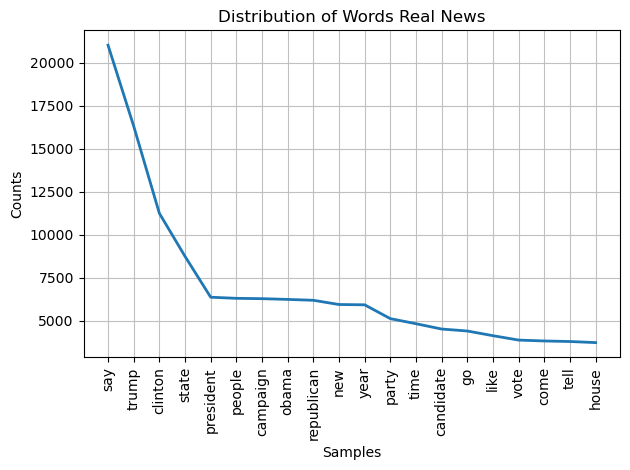

In [27]:
# Split the lemmas into individual token words
real_news_lemmas_split = real_news_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
real_dist = FreqDist(real_news_lemmas_split)
ax = real_dist.plot(20, show = False, title='Distribution of Words Real News')
plt.tight_layout()
plt.savefig('real_news_req_dist.png')

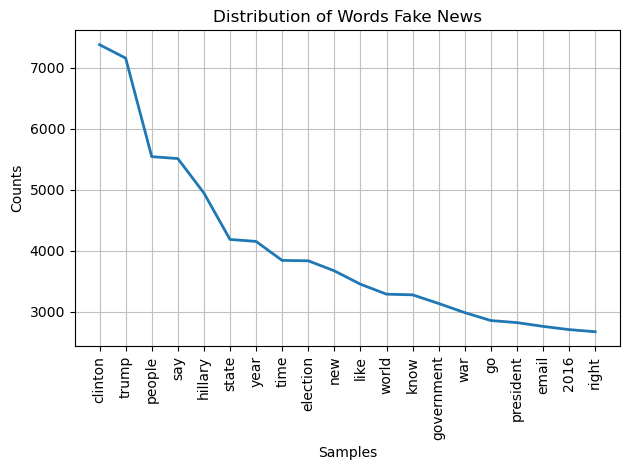

In [28]:
# Split the lemmas into individual token words
fake_news_lemmas_split = fake_news_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
fake_dist = FreqDist(fake_news_lemmas_split)
ax = fake_dist.plot(20, show=False, title='Distribution of Words Fake News')
plt.tight_layout()
plt.savefig('fake_news_freq_dist.png')

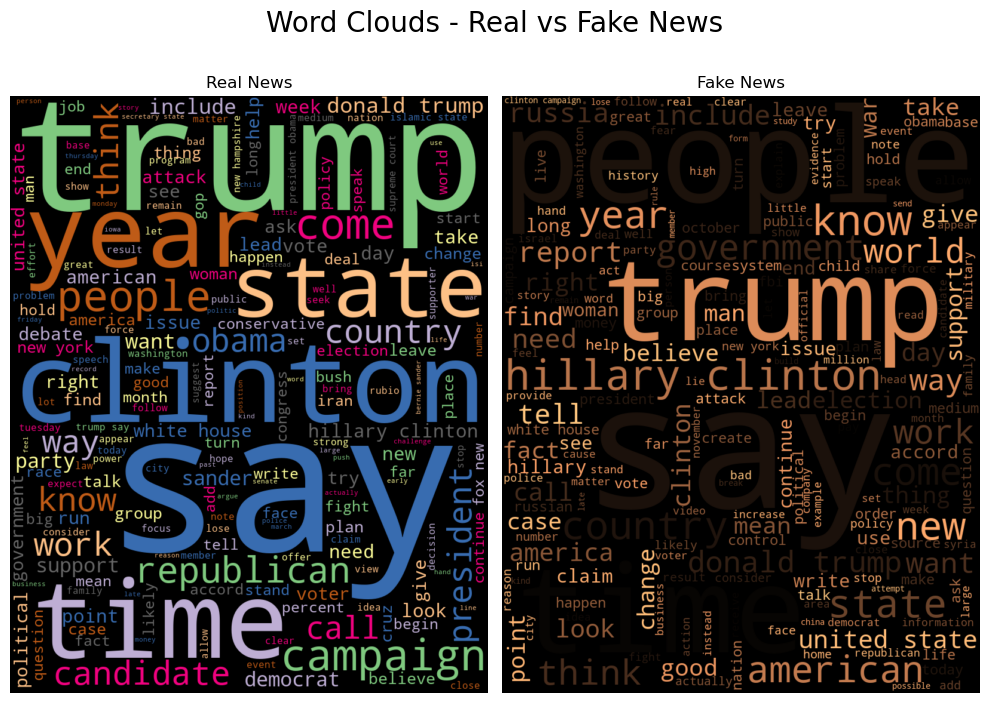

In [29]:
# Make word clouds of raw text
# Create an instance of a WordCloud and use the generate method
real_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 3, colormap="Accent",
                     ).generate(real_news_lemmas)
fake_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 3,
                       colormap="copper",
                      ).generate(fake_news_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(real_cloud, interpolation='bilinear')
axes[0].set_title("Real News")
axes[1].imshow(fake_cloud, interpolation='bilinear')
axes[1].set_title("Fake News")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Real vs Fake News', fontsize=20, y=1.05);

# Text Classification with Sklearn

### 2.  Prepare Imports and Functions

In [72]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
pd.set_option('display.max_colwidth',300)

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

### 3. Prepare the Data

In [60]:
# Define X and y
X= dflc['lemmas']
y= dflc['label']

In [61]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

### 4.  Prepare parameter grids for your grid search

In [62]:
# instantiate a vectorizer with english stopwords
vectorizer = CountVectorizer(stop_words='english')

# Fit it on the data 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [63]:
clf = RandomForestClassifier()
clf.fit(X_train_vec, y_train)


RandomForestClassifier()

In [64]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', CountVectorizer()),
                     ('clf',RandomForestClassifier())])

In [65]:
clf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('clf', RandomForestClassifier())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': RandomForestClassifier(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': None,
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_nodes': None,
 'clf__max_samples': None,
 'clf__min_impu

In [76]:
# Define params to try for both vectorizers
param_grid_shared = {
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    "vectorizer__ngram_range": [(1, 1), (1, 2)]}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared}

# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    **param_grid_shared}

# combine into list of params
vect_params_combined = [param_grid_count, param_grid_tfidf]

In [75]:
## Create parameter grids for 2 models
param_grid_RF = {
    'clf' : [RandomForestClassifier(random_state = 42)],
    'clf__max_depth' : [5, None],
    'clf__min_samples_leaf' : [1, 2],
}

param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],}

# combine into list of params
model_params_combined = [param_grid_RF, param_grid_MNB]

In [77]:
## Use itertools to create all the combinations of each

paired_param_grids = list(itertools.product(vect_params_combined, model_params_combined))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]},
 {'clf': [RandomForestClassifier(random_state=42)],
  'clf__max_depth': [5, None],
  'clf__min_samples_leaf': [1, 2]})

In [79]:
# Create a for loop

final_params = []

for vector_params, model_params in paired_param_grids:
    combined = {**vector_params,  **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'vectorizer__ngram_range': [(1, 1), (1, 2)],
 'clf': [RandomForestClassifier(random_state=42)],
 'clf__max_depth': [5, None],
 'clf__min_samples_leaf': [1, 2]}

In [ ]:
# Run GridSearchCV
grid_search = GridSearchCV(clf_pipe, final_params, cv=3, scoring='accuracy',
                           verbose=1, n_jobs=-1)

## fit model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


### 5. Create the best model using GridSearchCV

In [ ]:
grid_search.best_params_

In [ ]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

### 6.  Evaluate your best model 